# [GD]CutMix_Mixup

## 라이브러리 확인

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

* GPU 확인

In [2]:
tf.config.list_physical_devices('GPU')

2022-10-05 19:00:58.333026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 19:00:58.409876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 19:00:58.410038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Augmentation을 적용한 데이터셋 만들기

### Dataset 불러오기

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2022-10-05 19:00:58.478343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 19:00:58.480327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 19:00:58.480666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 19:00:58.480788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

* 우리가 사용할 데이터셋의 class의 개수를 구합니다.

In [4]:
num_classes = ds_info.features["label"].num_classes

### CutMix

* Get clipbox

In [5]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    
    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

* Mix 2 images

In [6]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1] 
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

* Mix 2 labels

In [7]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_label

* CutMix 함수

In [8]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### MixUp

* Mix up 2 images

In [9]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
        
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

* MixUp 함수

In [10]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 전처리 함수

In [11]:
# 정규화 및 크기 조정
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# augment 함수
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# one-hot encoding
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

### 데이터 생성

* No Augmentation
* 기본 Augmentation
* 기본 + CutMix 적용
* 기본 + Mixup 적용

In [12]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 2. 모델 만들기

* 기본 ResNet - ImageNet으로 훈련됨

In [13]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

* Augmentation을 적용한 dataset으로 학습할 ResNet

In [14]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

* CutMix를 적용한 dataset으로 학습할 ResNet

In [15]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

* MixUp을 적용한 dataset으로 학습할 ResNet

In [16]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 3. 모델 훈련하기

* EPOCH 설정

In [17]:
EPOCH = 15
# EPOCH = 3


* 기본 ResNet

In [18]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


2022-10-05 19:01:14.122131: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


750/750 [==============================] - 117s 145ms/step - loss: 2.1995 - accuracy: 0.4484 - val_loss: 3.2522 - val_accuracy: 0.2137
Epoch 2/15
750/750 [==============================] - 109s 145ms/step - loss: 0.7216 - accuracy: 0.8016 - val_loss: 1.0042 - val_accuracy: 0.6969
Epoch 3/15
750/750 [==============================] - 109s 145ms/step - loss: 0.2237 - accuracy: 0.9552 - val_loss: 0.9750 - val_accuracy: 0.7126
Epoch 4/15
750/750 [==============================] - 108s 144ms/step - loss: 0.1201 - accuracy: 0.9823 - val_loss: 0.9644 - val_accuracy: 0.7215
Epoch 5/15
750/750 [==============================] - 108s 145ms/step - loss: 0.0415 - accuracy: 0.9965 - val_loss: 0.9325 - val_accuracy: 0.7324
Epoch 6/15
750/750 [==============================] - 108s 144ms/step - loss: 0.0305 - accuracy: 0.9982 - val_loss: 0.9800 - val_accuracy: 0.7249
Epoch 7/15
750/750 [==============================] - 108s 144ms/step - loss: 0.0194 - accuracy: 0.9985 - val_loss: 0.9573 - val_accura

* Augmentation 적용

In [19]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 115s 146ms/step - loss: 2.2409 - accuracy: 0.4392 - val_loss: 2.8863 - val_accuracy: 0.2867
Epoch 2/15
750/750 [==============================] - 109s 145ms/step - loss: 0.9840 - accuracy: 0.7182 - val_loss: 1.2118 - val_accuracy: 0.6503
Epoch 3/15
750/750 [==============================] - 108s 144ms/step - loss: 0.5425 - accuracy: 0.8498 - val_loss: 1.1429 - val_accuracy: 0.6695
Epoch 4/15
750/750 [==============================] - 109s 145ms/step - loss: 0.3386 - accuracy: 0.9147 - val_loss: 1.2235 - val_accuracy: 0.6574
Epoch 5/15
750/750 [==============================] - 108s 144ms/step - loss: 0.2172 - accuracy: 0.9496 - val_loss: 1.0609 - val_accuracy: 0.7058
Epoch 6/15
750/750 [==============================] - 108s 144ms/step - loss: 0.1439 - accuracy: 0.9705 - val_loss: 1.0916 - val_accuracy: 0.6967
Epoch 7/15
750/750 [==============================] - 108s 145ms/step - loss: 0.0963 - accuracy: 0.9833 - val_loss: 0.9483 -

* CutMix 적용

In [20]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 118s 150ms/step - loss: 3.8338 - accuracy: 0.2159 - val_loss: 3.4909 - val_accuracy: 0.1962
Epoch 2/15
750/750 [==============================] - 112s 149ms/step - loss: 2.9779 - accuracy: 0.4155 - val_loss: 1.3810 - val_accuracy: 0.6152
Epoch 3/15
750/750 [==============================] - 110s 147ms/step - loss: 2.6602 - accuracy: 0.5217 - val_loss: 1.7389 - val_accuracy: 0.5401
Epoch 4/15
750/750 [==============================] - 110s 147ms/step - loss: 2.4631 - accuracy: 0.5809 - val_loss: 1.3162 - val_accuracy: 0.6414
Epoch 5/15
750/750 [==============================] - 112s 150ms/step - loss: 2.2862 - accuracy: 0.6423 - val_loss: 1.3025 - val_accuracy: 0.6582
Epoch 6/15
750/750 [==============================] - 112s 150ms/step - loss: 2.2013 - accuracy: 0.6713 - val_loss: 1.1746 - val_accuracy: 0.6797
Epoch 7/15
750/750 [==============================] - 112s 149ms/step - loss: 2.1300 - accuracy: 0.6925 - val_loss: 1.1555 -

* MixUp 적용

In [21]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 116s 150ms/step - loss: 3.7152 - accuracy: 0.2467 - val_loss: 3.9577 - val_accuracy: 0.1295
Epoch 2/15
750/750 [==============================] - 112s 149ms/step - loss: 2.8712 - accuracy: 0.4730 - val_loss: 1.6182 - val_accuracy: 0.5513
Epoch 3/15
750/750 [==============================] - 113s 151ms/step - loss: 2.5820 - accuracy: 0.5812 - val_loss: 1.3815 - val_accuracy: 0.6269
Epoch 4/15
750/750 [==============================] - 113s 150ms/step - loss: 2.3946 - accuracy: 0.6510 - val_loss: 1.2709 - val_accuracy: 0.6454
Epoch 5/15
750/750 [==============================] - 112s 150ms/step - loss: 2.2901 - accuracy: 0.6964 - val_loss: 1.2690 - val_accuracy: 0.6510
Epoch 6/15
750/750 [==============================] - 112s 150ms/step - loss: 2.1967 - accuracy: 0.7337 - val_loss: 1.2535 - val_accuracy: 0.6621
Epoch 7/15
750/750 [==============================] - 112s 150ms/step - loss: 2.1196 - accuracy: 0.7631 - val_loss: 1.2294 -

## 4. 훈련 과정 시각화하기

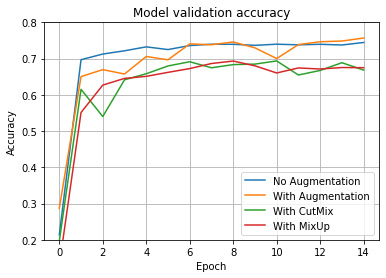

In [23]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug.history['val_accuracy'])
plt.plot(history_resnet50_cutmix.history['val_accuracy'])
plt.plot(history_resnet50_mixup.history['val_accuracy'])

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp'], loc='lower right')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.2, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

* 확대해서 보겠습니다.

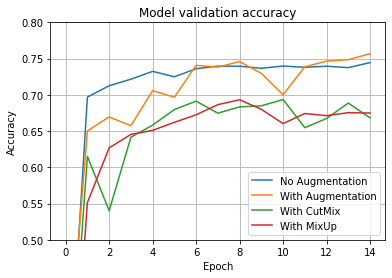

In [24]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug.history['val_accuracy'])
plt.plot(history_resnet50_cutmix.history['val_accuracy'])
plt.plot(history_resnet50_mixup.history['val_accuracy'])

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp'], loc='lower right')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.5, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

* CutMix, MixUp보다는 No Augmentation과 Augmentation을 적용한 것이 더 높게 나옵니다.
* 초반에는 No Augmentationdl 더 높게 나오지만 Epoch가 증가함에 따라서 Augmentation을 적용한 것이 더 높게 나옵니다.
* Dataset과 Augmentation의 종류에 따라 accuracy가 다르게 나올 것 같지만.
* one-hot이 적용된 것이 낮은 epoch에서는 높게 나오는 것 같습니다.

### 회고

* 이번 프로젝트에서 어려웠던 점
    - CutMix와 MixUp의 함수의 내용을 변경하고 싶지만 rand가 아닌 다른 좋은 방법이 떠오르지않았습니다. 
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된점
    - CutMix와 MixUp을 적용한다고 더 좋은 Accuracy가 나오지 않습니다.
  * 아직 모호한 점
    - CutMix와 MixUp의 Accuracy가 다른 Augmentation이나 Augmentation 비적용보다 낮게 나오는 것이 dataset에 의해서라고 생각되지만 확실하지 않습니다. 
* 루브릭 평가를 맞추기 위해 시도한 점
    - 모델 확인을 위해 최소한의 Epoch = 15 을 적용하였습니다.
    - Accuracy 비교를 위해 그래프를 그렸습니다.